In [1]:
import torch, torchvision
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import cv2, os
from pathlib import Path
from tqdm import tqdm
import shutil, itertools

device = "cuda" if torch.cuda.is_available() else "cpu"

## Human Masking Images

In [2]:
# Load COCO-pre-trained Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device).eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
@torch.inference_mode()
def mask_humans_pil(
    img: Image.Image,
    score_thresh: float = 0.5,
    fill_mode: str = "mean",   # "mean" | "black" | "gray"
):
    """
    Return a copy of `img` where every pixel inside a detected person
    is replaced by the frame average (paper-style) or a solid colour.
    """
    tensor = TF.to_tensor(img).to(device).unsqueeze(0)        # 1×3×H×W
    out = model(tensor)[0]                                    # dict

    keep = (out["labels"] == 1) & (out["scores"] > score_thresh)
    if keep.sum() == 0:
        return img.copy()                                     # no humans

    # Union of all person masks
    masks = (out["masks"][keep, 0].sigmoid() > 0.5).any(0)    # H×W bool
    mask_np = masks.cpu().numpy()

    arr = np.array(img)
    if fill_mode == "mean":
        fill_value = arr.mean(axis=(0, 1), keepdims=True).astype(arr.dtype)
    elif fill_mode == "gray":
        fill_value = np.array([127, 127, 127], dtype=arr.dtype)
    else:  # "black"
        fill_value = 0
    arr[mask_np] = fill_value
    return Image.fromarray(arr)


In [38]:
from itertools import islice

def chunks(iterable, n):
    "Yield successive n-sized lists from iterable"
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch

def mask_folder_batch(
    in_root: str | Path,
    out_root: str | Path,
    *,
    ext=".jpg",
    score_thresh=0.5,
    batch_size=4,
    recursive=True,
    clear_out=True,
    fill_mode="mean",           # mean / black / gray
):
    """
    Same API as mask_folder, but runs Mask R-CNN on <batch_size> frames
    at once for higher throughput.
    """
    in_root, out_root = Path(in_root), Path(out_root)
    if clear_out and out_root.exists():
        shutil.rmtree(out_root)

    pattern = f"**/*{ext}" if recursive else f"*{ext}"
    files = sorted(in_root.glob(pattern))
    print(f"{len(files)} frame(s) found → processing in batches of {batch_size}")

    for batch_paths in tqdm(list(chunks(files, batch_size))):
        # -------- 1. load & stack tensors ------------------------------------
        imgs_pil   = [Image.open(p).convert("RGB") for p in batch_paths]
        tensors    = [TF.to_tensor(im) for im in imgs_pil]
        tensor_cat = torch.stack(tensors).to(device)          # B×3×H×W

        # -------- 2. forward pass -------------------------------------------
        with torch.inference_mode():
            outs = model(tensor_cat)

        # -------- 3. post-process each frame in the batch -------------------
        for src_path, img, out in zip(batch_paths, imgs_pil, outs):
            keep = (out["labels"] == 1) & (out["scores"] > score_thresh)
            if keep.sum() == 0:
                img_masked = img
            else:
                masks = (out["masks"][keep, 0].sigmoid() > 0.5).any(0).cpu().numpy()
                arr = np.array(img)
                if fill_mode == "mean":
                    fill_val = arr.mean(axis=(0, 1), keepdims=True).astype(arr.dtype)
                elif fill_mode == "gray":
                    fill_val = np.array([127, 127, 127], dtype=arr.dtype)
                else:  # black
                    fill_val = 0
                arr[masks] = fill_val
                img_masked = Image.fromarray(arr)

            dst = out_root / src_path.relative_to(in_root)
            dst.parent.mkdir(parents=True, exist_ok=True)
            img_masked.save(dst)


In [39]:
in_root  = "datasets/UCF-101-JPG/Archery/"            # e.g. ".../train_frames"
out_root = "masking/"          # e.g. ".../train_frames_masked"

mask_folder_batch(
    in_root,
    out_root,
    batch_size = 8,     # tune for your GPU
    score_thresh = 0.55
)

23795 frame(s) found → processing in batches of 8


  0%|          | 0/2975 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
# ── 0. Setup ────────────────────────────────────────────────────────────────
import torch, torchvision, time, shutil, queue, threading
from torchvision.io import read_file, decode_jpeg, write_jpeg
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# ── 1. Fast JPEG -> Tensor on the GPU (nvJPEG) ──────────────────────────────
class FrameDS(Dataset):
    def __init__(self, root, ext=".jpg"):
        self.paths = sorted(Path(root).rglob(f"*{ext}"))
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p   = self.paths[idx]
        buf = read_file(str(p))                                   # raw bytes
        img = decode_jpeg(buf, device=device).float() / 255       # C×H×W
        return img, str(p)

# ── 2. Mask-R-CNN (person only) in half precision ──────────────────────────
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device).eval()

@torch.inference_mode()
def mask_batch(batch_imgs, score=0.5):
    with torch.cuda.amp.autocast(dtype=torch.float16):
        outs = model(batch_imgs)

    rect_masks = []
    for out, im in zip(outs, batch_imgs):
        keep = (out["labels"] == 1) & (out["scores"] > score)
        if keep.sum() == 0:
            rect_masks.append(None)
            continue

        H, W = im.shape[-2:]
        m = torch.zeros((H, W), dtype=torch.bool, device=im.device)
        for box in out["boxes"][keep]:
            x1, y1, x2, y2 = box.round().to(torch.long)
            x1, y1 = x1.clamp(0, W - 1), y1.clamp(0, H - 1)
            x2, y2 = x2.clamp(0, W - 1), y2.clamp(0, H - 1)
            m[y1:y2 + 1, x1:x2 + 1] = True
        rect_masks.append(m)
    return rect_masks

# ── 3. Async disk writer (so saving doesn’t block the GPU) ─────────────────
def writer_thread(q, out_root):
    while True:
        item = q.get()
        if item is None: break
        img, src_path = item
        dst = out_root / Path(src_path).relative_to(in_root)
        dst.parent.mkdir(parents=True, exist_ok=True)
        # uint8 tensor expected by write_jpeg
        write_jpeg((img.clamp(0,1)*255).byte().cpu(), str(dst), quality=95)
        q.task_done()

# ── 4. One-liner “train-loop” that ties it all together ────────────────────
def mask_folder_gpu(in_root, out_root,
                    batch_size=8, workers=4, score=0.5):

    ds  = FrameDS(in_root)
    dl  = DataLoader(ds, batch_size=batch_size, num_workers=workers,
                     pin_memory=False, shuffle=False, drop_last=False)

    if out_root.exists(): shutil.rmtree(out_root)
    q = queue.Queue(maxsize=32)
    th = threading.Thread(target=writer_thread, args=(q, out_root), daemon=True)
    th.start()

    t0 = time.time()
    for imgs, paths in tqdm(dl, total=len(dl)):
        imgs = imgs.to(device, non_blocking=True)
        masks = mask_batch(list(imgs), score)

        # fill on GPU
        for i, m in enumerate(masks):
            if m is not None:
                mean        = imgs[i].mean(dim=(1, 2), keepdim=True)   # (3,1,1)
                mean_pixel  = mean.view(3)        # (3,)
                mean_pixel  = mean_pixel[:, None] # (3,1)  ← add axis so (3,1) → (3,N)
                imgs[i][:, m] = mean_pixel        # OK
        # enqueue for compression + write
        for im, p in zip(imgs, paths): q.put((im, p))

    q.join(); q.put(None); th.join()
    print(f"Done in {(time.time()-t0):.1f}s → {len(ds)/(time.time()-t0):.1f} fps")

In [5]:
# ── 5. Run it ───────────────────────────────────────────────────────────────
in_root  = Path("datasets/UCF-101-JPG/Archery/")            # e.g. ".../train_frames"
out_root = Path("masking/")          # e.g. ".../train_frames_masked"

mask_folder_gpu(in_root, 
                out_root,
                batch_size=8,   # ↑ until you hit ~90 % GPU util or OOM
                workers=0,      # CPU threads that prefetch & decode bytes
                score=0.2)

  0%|          | 0/2975 [00:00<?, ?it/s]

Done in 647.5s → 36.8 fps


## Dummy Numpy Mask

In [104]:
# %%
"""
Generate a dummy detection .npy file that mirrors the real directory tree,
ignoring hidden folders, but this time using *larger* random bounding boxes.
"""

import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

# ─── config ───────────────────────────────────────────
video_root   = Path("datasets/UCF-101-JPG")          # class/video/frame.jpg tree
out_file     = Path("dummy_detections.npy")          # output file
seed         = 42
max_boxes    = 3

# If you know your real resolution, set it here.
# (Purely for generating boxes; the file structure is independent of this.)
img_w, img_h = 320, 240

# Size range for boxes *relative to* frame size
BOX_MIN_FRAC = 0.10          # 10 % of width/height
BOX_MAX_FRAC = 0.50          # 50 % of width/height  ← bigger than before

np.random.seed(seed)

# ─── helper ───────────────────────────────────────────
def is_hidden(p: Path) -> bool:
    return p.name.startswith('.') or 'ipynb_checkpoints' in p.name

def random_boxes(n: int) -> np.ndarray:
    """
    Return (n,5) float32 array of random boxes:
    (x1, y1, x2, y2, score) clipped to image bounds.

    Box width/height ∈ [BOX_MIN_FRAC, BOX_MAX_FRAC] × image_(w|h)
    """
    if n == 0:
        return np.zeros((0, 5), dtype=np.float32)

    # random top-left corner
    x1 = np.random.uniform(0, img_w * (1 - BOX_MIN_FRAC), size=n)
    y1 = np.random.uniform(0, img_h * (1 - BOX_MIN_FRAC), size=n)

    # random width / height (now wider range → bigger boxes)
    widths  = np.random.uniform(img_w * BOX_MIN_FRAC, img_w * BOX_MAX_FRAC, size=n)
    heights = np.random.uniform(img_h * BOX_MIN_FRAC, img_h * BOX_MAX_FRAC, size=n)

    # ensure boxes stay inside frame
    x2 = np.clip(x1 + widths,  0, img_w)
    y2 = np.clip(y1 + heights, 0, img_h)

    scores = np.random.uniform(0.3, 1.0, size=n)      # plausible confidence
    return np.stack([x1, y1, x2, y2, scores], axis=1).astype(np.float32)

# ─── build nested dict ───────────────────────────────
all_dets = {}

for class_dir in tqdm(sorted(video_root.iterdir()), desc="class"):
    if not class_dir.is_dir() or is_hidden(class_dir):
        continue
    cls_name = class_dir.name
    all_dets[cls_name] = {}

    for vid_dir in tqdm(sorted(class_dir.iterdir()), leave=False, desc=cls_name):
        if not vid_dir.is_dir() or is_hidden(vid_dir):
            continue
        vid11 = vid_dir.name
        all_dets[cls_name][vid11] = {}

        frames = sorted(vid_dir.glob("*.jpg"))
        for idx, _ in enumerate(frames, start=1):          # frame indices are 1-based
            n = np.random.randint(0, max_boxes + 1)        # 0…max_boxes boxes
            all_dets[cls_name][vid11][idx] = {"human_boxes": random_boxes(n)}

# ─── save ────────────────────────────────────────────
np.save(out_file, all_dets, allow_pickle=True)
print(f"✅  Dummy detection file written → {out_file}")


class:   0%|          | 0/102 [00:00<?, ?it/s]

ApplyEyeMakeup:   0%|          | 0/145 [00:00<?, ?it/s]

ApplyLipstick:   0%|          | 0/114 [00:00<?, ?it/s]

Archery:   0%|          | 0/145 [00:00<?, ?it/s]

BabyCrawling:   0%|          | 0/132 [00:00<?, ?it/s]

BalanceBeam:   0%|          | 0/108 [00:00<?, ?it/s]

BandMarching:   0%|          | 0/155 [00:00<?, ?it/s]

BaseballPitch:   0%|          | 0/150 [00:00<?, ?it/s]

Basketball:   0%|          | 0/134 [00:00<?, ?it/s]

BasketballDunk:   0%|          | 0/131 [00:00<?, ?it/s]

BenchPress:   0%|          | 0/160 [00:00<?, ?it/s]

Biking:   0%|          | 0/134 [00:00<?, ?it/s]

Billiards:   0%|          | 0/150 [00:00<?, ?it/s]

BlowDryHair:   0%|          | 0/131 [00:00<?, ?it/s]

BlowingCandles:   0%|          | 0/109 [00:00<?, ?it/s]

BodyWeightSquats:   0%|          | 0/112 [00:00<?, ?it/s]

Bowling:   0%|          | 0/155 [00:00<?, ?it/s]

BoxingPunchingBag:   0%|          | 0/163 [00:00<?, ?it/s]

BoxingSpeedBag:   0%|          | 0/134 [00:00<?, ?it/s]

BreastStroke:   0%|          | 0/101 [00:00<?, ?it/s]

BrushingTeeth:   0%|          | 0/131 [00:00<?, ?it/s]

CleanAndJerk:   0%|          | 0/112 [00:00<?, ?it/s]

CliffDiving:   0%|          | 0/138 [00:00<?, ?it/s]

CricketBowling:   0%|          | 0/139 [00:00<?, ?it/s]

CricketShot:   0%|          | 0/167 [00:00<?, ?it/s]

CuttingInKitchen:   0%|          | 0/110 [00:00<?, ?it/s]

Diving:   0%|          | 0/150 [00:00<?, ?it/s]

Drumming:   0%|          | 0/161 [00:00<?, ?it/s]

Fencing:   0%|          | 0/111 [00:00<?, ?it/s]

FieldHockeyPenalty:   0%|          | 0/126 [00:00<?, ?it/s]

FloorGymnastics:   0%|          | 0/125 [00:00<?, ?it/s]

FrisbeeCatch:   0%|          | 0/126 [00:00<?, ?it/s]

FrontCrawl:   0%|          | 0/137 [00:00<?, ?it/s]

GolfSwing:   0%|          | 0/139 [00:00<?, ?it/s]

Haircut:   0%|          | 0/130 [00:00<?, ?it/s]

HammerThrow:   0%|          | 0/150 [00:00<?, ?it/s]

Hammering:   0%|          | 0/140 [00:00<?, ?it/s]

HandstandPushups:   0%|          | 0/128 [00:00<?, ?it/s]

HandstandWalking:   0%|          | 0/111 [00:00<?, ?it/s]

HeadMassage:   0%|          | 0/147 [00:00<?, ?it/s]

HighJump:   0%|          | 0/123 [00:00<?, ?it/s]

HorseRace:   0%|          | 0/124 [00:00<?, ?it/s]

HorseRiding:   0%|          | 0/164 [00:00<?, ?it/s]

HulaHoop:   0%|          | 0/125 [00:00<?, ?it/s]

IceDancing:   0%|          | 0/158 [00:00<?, ?it/s]

JavelinThrow:   0%|          | 0/117 [00:00<?, ?it/s]

JugglingBalls:   0%|          | 0/121 [00:00<?, ?it/s]

JumpRope:   0%|          | 0/144 [00:00<?, ?it/s]

JumpingJack:   0%|          | 0/123 [00:00<?, ?it/s]

Kayaking:   0%|          | 0/141 [00:00<?, ?it/s]

Knitting:   0%|          | 0/123 [00:00<?, ?it/s]

LongJump:   0%|          | 0/131 [00:00<?, ?it/s]

Lunges:   0%|          | 0/127 [00:00<?, ?it/s]

MilitaryParade:   0%|          | 0/125 [00:00<?, ?it/s]

Mixing:   0%|          | 0/136 [00:00<?, ?it/s]

MoppingFloor:   0%|          | 0/110 [00:00<?, ?it/s]

Nunchucks:   0%|          | 0/132 [00:00<?, ?it/s]

ParallelBars:   0%|          | 0/114 [00:00<?, ?it/s]

PizzaTossing:   0%|          | 0/113 [00:00<?, ?it/s]

PlayingCello:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingDaf:   0%|          | 0/151 [00:00<?, ?it/s]

PlayingDhol:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingFlute:   0%|          | 0/155 [00:00<?, ?it/s]

PlayingGuitar:   0%|          | 0/160 [00:00<?, ?it/s]

PlayingPiano:   0%|          | 0/105 [00:00<?, ?it/s]

PlayingSitar:   0%|          | 0/157 [00:00<?, ?it/s]

PlayingTabla:   0%|          | 0/111 [00:00<?, ?it/s]

PlayingViolin:   0%|          | 0/100 [00:00<?, ?it/s]

PoleVault:   0%|          | 0/149 [00:00<?, ?it/s]

PommelHorse:   0%|          | 0/123 [00:00<?, ?it/s]

PullUps:   0%|          | 0/100 [00:00<?, ?it/s]

Punch:   0%|          | 0/160 [00:00<?, ?it/s]

PushUps:   0%|          | 0/102 [00:00<?, ?it/s]

Rafting:   0%|          | 0/111 [00:00<?, ?it/s]

RockClimbingIndoor:   0%|          | 0/144 [00:00<?, ?it/s]

RopeClimbing:   0%|          | 0/119 [00:00<?, ?it/s]

Rowing:   0%|          | 0/137 [00:00<?, ?it/s]

SalsaSpin:   0%|          | 0/133 [00:00<?, ?it/s]

ShavingBeard:   0%|          | 0/161 [00:00<?, ?it/s]

Shotput:   0%|          | 0/144 [00:00<?, ?it/s]

SkateBoarding:   0%|          | 0/120 [00:00<?, ?it/s]

Skiing:   0%|          | 0/135 [00:00<?, ?it/s]

Skijet:   0%|          | 0/100 [00:00<?, ?it/s]

SkyDiving:   0%|          | 0/110 [00:00<?, ?it/s]

SoccerJuggling:   0%|          | 0/147 [00:00<?, ?it/s]

SoccerPenalty:   0%|          | 0/137 [00:00<?, ?it/s]

StillRings:   0%|          | 0/112 [00:00<?, ?it/s]

SumoWrestling:   0%|          | 0/116 [00:00<?, ?it/s]

Surfing:   0%|          | 0/126 [00:00<?, ?it/s]

Swing:   0%|          | 0/131 [00:00<?, ?it/s]

TableTennisShot:   0%|          | 0/140 [00:00<?, ?it/s]

TaiChi:   0%|          | 0/100 [00:00<?, ?it/s]

TennisSwing:   0%|          | 0/166 [00:00<?, ?it/s]

ThrowDiscus:   0%|          | 0/130 [00:00<?, ?it/s]

TrampolineJumping:   0%|          | 0/119 [00:00<?, ?it/s]

Typing:   0%|          | 0/136 [00:00<?, ?it/s]

UnevenBars:   0%|          | 0/104 [00:00<?, ?it/s]

VolleyballSpiking:   0%|          | 0/116 [00:00<?, ?it/s]

WalkingWithDog:   0%|          | 0/123 [00:00<?, ?it/s]

WallPushups:   0%|          | 0/130 [00:00<?, ?it/s]

WritingOnBoard:   0%|          | 0/152 [00:00<?, ?it/s]

YoYo:   0%|          | 0/128 [00:00<?, ?it/s]

✅  Dummy detection file written → dummy_detections.npy


## Numpy mask

In [8]:
# %%
"""
Human-detector preprocessing with debug prints
────────────────────────────────────────────────────────
• Traverses UCF-101-JPG   class/video/frame.jpg tree
• Saves one nested dict in a .npy file
• Debug flags let you (1) restrict the tree depth and
  (2) see live feedback on progress & detections.
"""

# ─── imports ──────────────────────────────────────────
import time
import torch, torchvision, numpy as np
from torchvision.io import read_image
from pathlib import Path
from tqdm.auto import tqdm

# ─── config ───────────────────────────────────────────
video_root   = Path("datasets/UCF-101-JPG")            # class/video/frame.jpg tree
out_file     = Path("detection_train_merged_rearranged_2.0.npy")
score_thr    = 0.2
batch_size   = 32
device       = "cuda" if torch.cuda.is_available() else "cpu"

# ─── debug / filter switches ──────────────────────────
DEBUG_ONE_CLASS = False        # True → stop after first class directory
DEBUG_ONE_VIDEO = False        # True → stop after first video directory
KEEP_CLASS      = None         # e.g. "ApplyEyeMakeup"
KEEP_VIDEO      = None         # e.g. "ApplyEyeMakeup_v01"

# Debug output verbosity
VERBOSE                 = False       # master switch
PRINT_EVERY_BATCH       = False       # print info for every Nth batch
PRINT_BATCH_EVERY_N     = 5          # change N as needed
PRINT_GPU_MEM_EVERY_N   = 50         # also prints GPU memory every N frames

# ─── helper: debug print ──────────────────────────────
def dprint(msg):
    if VERBOSE:
        print(msg, flush=True)

# ─── detector ─────────────────────────────────────────
dprint(f"🔧  Initialising Mask R-CNN on {device!r}")
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device).eval()

@torch.inference_mode()
def detect_batch(imgs):
    with torch.cuda.amp.autocast(dtype=torch.float16):
        return model(imgs)

# ─── counters for a final summary ─────────────────────
n_classes = n_videos = n_frames_total = 0
t_start_overall = time.time()

# ─── build nested dict {class}{vid11}{frame}{'human_boxes'} ────────────────
all_dets = {}

for c_idx, class_dir in enumerate(tqdm(sorted(video_root.iterdir()), desc="class")):
    if not class_dir.is_dir():
        continue
    if KEEP_CLASS and class_dir.name != KEEP_CLASS:
        continue
    if DEBUG_ONE_CLASS and c_idx > 0:
        break

    cls_name = class_dir.name
    n_classes += 1
    all_dets[cls_name] = {}

    video_dirs = [d for d in sorted(class_dir.iterdir()) if d.is_dir()]
    dprint(f"\n📂  Class [{cls_name}] — {len(video_dirs)} video folders")

    for v_idx, vid_dir in enumerate(tqdm(video_dirs, leave=False, desc=cls_name)):
        if KEEP_VIDEO and vid_dir.name != KEEP_VIDEO:
            continue
        if DEBUG_ONE_VIDEO and v_idx > 0:
            break

        vid11   = vid_dir.name                    # first 11 chars
        frames  = sorted(vid_dir.glob("*.jpg"))
        T       = len(frames)
        n_videos += 1
        all_dets[cls_name][vid11] = {}

        dprint(f"  🎞  Video [{vid_dir.name}] — {T} frames")

        # mini-batch inference for speed
        t_vid = time.time()
        for i in range(0, T, batch_size):
            batch_paths = frames[i:i+batch_size]
            imgs_cpu    = [read_image(str(p)).float()/255 for p in batch_paths]
            imgs_gpu    = torch.stack(imgs_cpu).to(device).half()
            outs        = detect_batch(imgs_gpu)

            # debug: how many human detections in this batch?
            if PRINT_EVERY_BATCH and (i//batch_size) % PRINT_BATCH_EVERY_N == 0:
                kept_sum = int(sum(((o["labels"] == 1) & (o["scores"] > score_thr)).sum() for o in outs))
                dprint(f"     ▸ batch {i:5d}-{i+len(batch_paths)-1:<5d} — kept {kept_sum} boxes")

            for j, out in enumerate(outs, start=i):
                keep = (out["labels"] == 1) & (out["scores"] > score_thr)
                if keep.sum() == 0:
                    boxes = np.zeros((0, 5), dtype=np.float32)
                else:
                    b = out["boxes"][keep].float().cpu().numpy()        # (N,4)
                    s = out["scores"][keep].float().cpu().numpy()[:, None]
                    boxes = np.hstack([b, s]).astype(np.float32)        # (N,5)

                frame_idx = j + 1                                       # 1-based
                all_dets[cls_name][vid11][frame_idx] = {"human_boxes": boxes}

                # optional GPU memory read-out
                if device == "cuda" and frame_idx % PRINT_GPU_MEM_EVERY_N == 0:
                    free_mem, total_mem = torch.cuda.mem_get_info()
                    dprint(f"         GPU mem: {(total_mem-free_mem)/1e9:4.1f} GB / {total_mem/1e9:.1f} GB used")

        t_vid = time.time() - t_vid
        n_frames_total += T
        dprint(f"  ⏱  Finished video in {t_vid:.1f}s "
               f"(≈{1000*t_vid/max(T,1):.1f} ms per frame)")

# ─── save one pickled .npy file ────────────────────────────────────────────
np.save(out_file, all_dets, allow_pickle=True)
t_total = time.time() - t_start_overall

dprint("\n────────────────────────────────────────────────────────")
dprint(f"✅  wrote detections for {n_classes} classes, "
       f"{n_videos} videos, {n_frames_total} frames")
dprint(f"📁  Output: {out_file}")
dprint(f"🕒  Total runtime: {t_total/60:.1f} min")


class:   0%|          | 0/102 [00:00<?, ?it/s]

.ipynb_checkpoints: 0it [00:00, ?it/s]

ApplyEyeMakeup:   0%|          | 0/145 [00:00<?, ?it/s]

ApplyLipstick:   0%|          | 0/114 [00:00<?, ?it/s]

Archery:   0%|          | 0/145 [00:00<?, ?it/s]

BabyCrawling:   0%|          | 0/132 [00:00<?, ?it/s]

BalanceBeam:   0%|          | 0/108 [00:00<?, ?it/s]

BandMarching:   0%|          | 0/155 [00:00<?, ?it/s]

BaseballPitch:   0%|          | 0/150 [00:00<?, ?it/s]

Basketball:   0%|          | 0/134 [00:00<?, ?it/s]

BasketballDunk:   0%|          | 0/131 [00:00<?, ?it/s]

BenchPress:   0%|          | 0/160 [00:00<?, ?it/s]

Biking:   0%|          | 0/134 [00:00<?, ?it/s]

Billiards:   0%|          | 0/150 [00:00<?, ?it/s]

BlowDryHair:   0%|          | 0/131 [00:00<?, ?it/s]

BlowingCandles:   0%|          | 0/109 [00:00<?, ?it/s]

BodyWeightSquats:   0%|          | 0/112 [00:00<?, ?it/s]

Bowling:   0%|          | 0/155 [00:00<?, ?it/s]

BoxingPunchingBag:   0%|          | 0/163 [00:00<?, ?it/s]

BoxingSpeedBag:   0%|          | 0/134 [00:00<?, ?it/s]

BreastStroke:   0%|          | 0/101 [00:00<?, ?it/s]

BrushingTeeth:   0%|          | 0/131 [00:00<?, ?it/s]

CleanAndJerk:   0%|          | 0/112 [00:00<?, ?it/s]

CliffDiving:   0%|          | 0/138 [00:00<?, ?it/s]

CricketBowling:   0%|          | 0/139 [00:00<?, ?it/s]

CricketShot:   0%|          | 0/167 [00:00<?, ?it/s]

CuttingInKitchen:   0%|          | 0/110 [00:00<?, ?it/s]

Diving:   0%|          | 0/150 [00:00<?, ?it/s]

Drumming:   0%|          | 0/161 [00:00<?, ?it/s]

Fencing:   0%|          | 0/111 [00:00<?, ?it/s]

FieldHockeyPenalty:   0%|          | 0/126 [00:00<?, ?it/s]

FloorGymnastics:   0%|          | 0/125 [00:00<?, ?it/s]

FrisbeeCatch:   0%|          | 0/126 [00:00<?, ?it/s]

FrontCrawl:   0%|          | 0/137 [00:00<?, ?it/s]

GolfSwing:   0%|          | 0/139 [00:00<?, ?it/s]

Haircut:   0%|          | 0/130 [00:00<?, ?it/s]

HammerThrow:   0%|          | 0/150 [00:00<?, ?it/s]

Hammering:   0%|          | 0/140 [00:00<?, ?it/s]

HandstandPushups:   0%|          | 0/128 [00:00<?, ?it/s]

HandstandWalking:   0%|          | 0/111 [00:00<?, ?it/s]

HeadMassage:   0%|          | 0/147 [00:00<?, ?it/s]

HighJump:   0%|          | 0/123 [00:00<?, ?it/s]

HorseRace:   0%|          | 0/124 [00:00<?, ?it/s]

HorseRiding:   0%|          | 0/164 [00:00<?, ?it/s]

HulaHoop:   0%|          | 0/125 [00:00<?, ?it/s]

IceDancing:   0%|          | 0/158 [00:00<?, ?it/s]

JavelinThrow:   0%|          | 0/117 [00:00<?, ?it/s]

JugglingBalls:   0%|          | 0/121 [00:00<?, ?it/s]

JumpRope:   0%|          | 0/144 [00:00<?, ?it/s]

JumpingJack:   0%|          | 0/123 [00:00<?, ?it/s]

Kayaking:   0%|          | 0/141 [00:00<?, ?it/s]

Knitting:   0%|          | 0/123 [00:00<?, ?it/s]

LongJump:   0%|          | 0/131 [00:00<?, ?it/s]

Lunges:   0%|          | 0/127 [00:00<?, ?it/s]

MilitaryParade:   0%|          | 0/125 [00:00<?, ?it/s]

Mixing:   0%|          | 0/136 [00:00<?, ?it/s]

MoppingFloor:   0%|          | 0/110 [00:00<?, ?it/s]

Nunchucks:   0%|          | 0/132 [00:00<?, ?it/s]

ParallelBars:   0%|          | 0/114 [00:00<?, ?it/s]

PizzaTossing:   0%|          | 0/113 [00:00<?, ?it/s]

PlayingCello:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingDaf:   0%|          | 0/151 [00:00<?, ?it/s]

PlayingDhol:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingFlute:   0%|          | 0/155 [00:00<?, ?it/s]

PlayingGuitar:   0%|          | 0/160 [00:00<?, ?it/s]

PlayingPiano:   0%|          | 0/105 [00:00<?, ?it/s]

PlayingSitar:   0%|          | 0/157 [00:00<?, ?it/s]

PlayingTabla:   0%|          | 0/111 [00:00<?, ?it/s]

PlayingViolin:   0%|          | 0/100 [00:00<?, ?it/s]

PoleVault:   0%|          | 0/149 [00:00<?, ?it/s]

PommelHorse:   0%|          | 0/123 [00:00<?, ?it/s]

PullUps:   0%|          | 0/100 [00:00<?, ?it/s]

Punch:   0%|          | 0/160 [00:00<?, ?it/s]

PushUps:   0%|          | 0/102 [00:00<?, ?it/s]

Rafting:   0%|          | 0/111 [00:00<?, ?it/s]

RockClimbingIndoor:   0%|          | 0/144 [00:00<?, ?it/s]

RopeClimbing:   0%|          | 0/119 [00:00<?, ?it/s]

Rowing:   0%|          | 0/137 [00:00<?, ?it/s]

SalsaSpin:   0%|          | 0/133 [00:00<?, ?it/s]

ShavingBeard:   0%|          | 0/161 [00:00<?, ?it/s]

Shotput:   0%|          | 0/144 [00:00<?, ?it/s]

SkateBoarding:   0%|          | 0/120 [00:00<?, ?it/s]

Skiing:   0%|          | 0/135 [00:00<?, ?it/s]

Skijet:   0%|          | 0/100 [00:00<?, ?it/s]

SkyDiving:   0%|          | 0/110 [00:00<?, ?it/s]

SoccerJuggling:   0%|          | 0/147 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
dets = np.load("detection_train_merged_rearranged_2.0.npy", allow_pickle=True).item()
print("classes  :", len(dets))
print("one class :", next(iter(dets)))
print("one video :", next(iter(dets[next(iter(dets))])))
print("frame 1 boxes shape :", 
      dets[next(iter(dets))][next(iter(dets[next(iter(dets))]))][1]['human_boxes'].shape)


classes  : 101
one class : ApplyEyeMakeup
one video : v_ApplyEyeMakeup_g01_c01
frame 1 boxes shape : (6, 5)


In [11]:
dets = np.load("detection_train_merged_rearranged.npy", allow_pickle=True).item()

# grab first class that actually contains videos
cls = next(k for k,v in dets.items() if len(v))
vid = next(iter(dets[cls]))
f   = next(iter(dets[cls][vid]))

print("class :", cls)
print("video :", vid)
print("frame :", f)
print("boxes :", dets[cls][vid][f]['human_boxes'].shape)

class : ApplyEyeMakeup
video : v_ApplyEyeM
frame : 1
boxes : (0, 5)


## Clean numpy file

In [13]:
import numpy as np
from pathlib import Path

npy_path = Path("detection_train_merged_rearranged_2.0.npy")   # <-- your file
backup   = npy_path.with_suffix(".bak.npy")                # safety copy

# 1) load the nested-dict detections
dets = np.load(npy_path, allow_pickle=True).item()

# 2) remove hidden “class” keys (like ".ipynb_checkpoints")
for cls in [c for c in dets if c.startswith('.')]:
    print("removing class key:", cls)
    dets.pop(cls, None)

# 3) remove hidden “video” keys inside each class, if any
for cls, vids in dets.items():
    for vid in [v for v in vids if v.startswith('.')]:
        print(f"removing video key: {cls}/{vid}")
        vids.pop(vid, None)

# 4) back-up original, then save the cleaned dict
npy_path.rename(backup)                       # keep the old file
np.save(npy_path, dets, allow_pickle=True)
print("✅ cleaned file saved:", npy_path)

# quick sanity check
clean = np.load(npy_path, allow_pickle=True).item()
print("n_classes (after clean):", len(clean))


removing class key: .ipynb_checkpoints
✅ cleaned file saved: detection_train_merged_rearranged_2.0.npy
n_classes (after clean): 101


## Verify

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display  # built-in in Jupyter

DETS_PATH = Path("detection_train_merged_rearranged_2.0_plus_dummy.npy")   # ← adjust
dets = np.load(DETS_PATH, allow_pickle=True).item()

rows = []
for cls, videos in dets.items():
    n_vids = len(videos)
    # get a sample video to peek at its frame count (skip empties)
    sample_vid = next((v for v in videos.values() if v), None)
    n_frames = len(sample_vid) if sample_vid else 0
    rows.append({"class": cls, "# videos": n_vids, "# frames/sample video": n_frames})

summary_df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(summary_df)               # shows an interactive table in Jupyter


,class,# videos,# frames/sample video
0,ApplyEyeMakeup,145,165
1,ApplyLipstick,114,149
2,Archery,145,131
3,BabyCrawling,132,165
4,BalanceBeam,108,126
...,...,...,...
96,VolleyballSpiking,116,93
97,WalkingWithDog,123,240
98,WallPushups,130,90
99,WritingOnBoard,152,153


In [21]:
def show_video_boxes(dets, cls, vid_key, frame_idx=1, max_boxes=5):
    """
    Pretty-print the first few boxes for a chosen frame.
    - cls       : class name (string)
    - vid_key   : the 11-char video key, e.g. 'v_ApplyEyeM'
    - frame_idx : 1-based frame index (as stored in the dict)
    """
    boxes = dets[cls][vid_key][frame_idx]['human_boxes']
    print(f"class : {cls}")
    print(f"video : {vid_key}")
    print(f"frame : {frame_idx}  –  {boxes.shape[0]} boxes")
    print(boxes[:max_boxes])

# example usage ------------------------------------------------------------
cls_name = summary_df.loc[0, "class"]          # first class in the table
vid_key  = next(iter(dets[cls_name]))          # first video under that class
show_video_boxes(dets, cls_name, vid_key, frame_idx=1)


class : ApplyEyeMakeup
video : v_ApplyEyeMakeup_g01_c01
frame : 1  –  8 boxes
[[101.6214       0.         319.54184    240.00002      0.9887396 ]
 [251.04007      5.6460757  319.6166     235.10393      0.8439361 ]
 [ 95.60457    153.25749    184.92076    240.00002      0.7952221 ]
 [ 81.92451     40.500706   233.27249    231.8993       0.6396938 ]
 [ 82.10901    101.947655   193.16304    236.45236      0.56542087]]


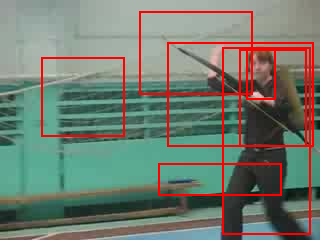

In [22]:
from PIL import Image, ImageDraw

def overlay_boxes(img_path, boxes, score_thr=0.0):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    for x1, y1, x2, y2, s in boxes:
        if s < score_thr:   # optional confidence filter
            continue
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    display(img)

cls_name = "Archery"
vid_key = "v_Archery_g01_c06"

# pick one frame file that matches the video & frame index you just inspected
img_path = (
    Path("datasets/UCF-101-JPG")        # root
    / cls_name                          # class folder
    / f"{vid_key}"                  # video folder (string → Path via /)
    / "image_00001.jpg"                 # frame file
)
overlay_boxes(img_path, dets[cls_name][vid_key][1]['human_boxes'])


##### 

## Add random detections to real detections

In [19]:
# %% [markdown]
# # Add dummy detections to an existing file
# This cell:
# 1. Loads a nested-dict detection file saved with `np.save(..., allow_pickle=True)`.
# 2. Appends 0–`max_new` random boxes per frame.
# 3. Writes the augmented structure back to disk.
#
# ▸ Adjust the CONFIG block and run.

# %% [code]  ------------------------------------------------ CONFIG
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm

in_file   = Path("detection_train_merged_rearranged_2.0.npy")          # ← existing file
out_file  = Path("detection_train_merged_rearranged_2.0_plus_dummy.npy")
max_new   = 3                               # max *additional* boxes / frame
seed      = 42                              # set -1 for nondeterministic
img_w, img_h = 320, 240                     # frame resolution (pixels)

BOX_MIN_FRAC = 0.10   # 10 % of w/h
BOX_MAX_FRAC = 0.50   # 50 %

# %% [code]  ------------------------------------------------ SETUP
if seed >= 0:
    np.random.seed(seed)

def random_boxes(n: int) -> np.ndarray:
    """Return (n,5) float32 array: x1,y1,x2,y2,score (clipped to frame)."""
    if n == 0:
        return np.zeros((0, 5), dtype=np.float32)

    x1 = np.random.uniform(0, img_w * (1 - BOX_MIN_FRAC), size=n)
    y1 = np.random.uniform(0, img_h * (1 - BOX_MIN_FRAC), size=n)
    w  = np.random.uniform(img_w * BOX_MIN_FRAC, img_w * BOX_MAX_FRAC, size=n)
    h  = np.random.uniform(img_h * BOX_MIN_FRAC, img_h * BOX_MAX_FRAC, size=n)

    x2 = np.clip(x1 + w,  0, img_w)
    y2 = np.clip(y1 + h,  0, img_h)
    scores = np.random.uniform(0.3, 1.0, size=n)

    return np.stack([x1, y1, x2, y2, scores], axis=1).astype(np.float32)

# %% [code]  ------------------------------------------------ LOAD
print(f"🔍 Loading {in_file} …")
det_tree = np.load(in_file, allow_pickle=True).item()   # nested dict

# %% [code]  ------------------------------------------------ AUGMENT
for cls_name, vid_dict in tqdm(det_tree.items(), desc="class"):
    for vid_name, frame_dict in tqdm(vid_dict.items(), leave=False, desc=cls_name):
        for frame_idx, ann in frame_dict.items():
            old = ann.get("human_boxes", np.zeros((0, 5), dtype=np.float32))
            n_new = np.random.randint(0, max_new + 1)
            new   = random_boxes(n_new)
            if n_new:
                ann["human_boxes"] = np.concatenate([old, new], axis=0)

print("✅  Dummy boxes added!")

# %% [code]  ------------------------------------------------ SAVE
out_file.parent.mkdir(parents=True, exist_ok=True)
np.save(out_file, det_tree, allow_pickle=True)
print(f"💾  Augmented detections written → {out_file}")


🔍 Loading detection_train_merged_rearranged_2.0.npy …


class:   0%|          | 0/101 [00:00<?, ?it/s]

ApplyEyeMakeup:   0%|          | 0/145 [00:00<?, ?it/s]

ApplyLipstick:   0%|          | 0/114 [00:00<?, ?it/s]

Archery:   0%|          | 0/145 [00:00<?, ?it/s]

BabyCrawling:   0%|          | 0/132 [00:00<?, ?it/s]

BalanceBeam:   0%|          | 0/108 [00:00<?, ?it/s]

BandMarching:   0%|          | 0/155 [00:00<?, ?it/s]

BaseballPitch:   0%|          | 0/150 [00:00<?, ?it/s]

Basketball:   0%|          | 0/134 [00:00<?, ?it/s]

BasketballDunk:   0%|          | 0/131 [00:00<?, ?it/s]

BenchPress:   0%|          | 0/160 [00:00<?, ?it/s]

Biking:   0%|          | 0/134 [00:00<?, ?it/s]

Billiards:   0%|          | 0/150 [00:00<?, ?it/s]

BlowDryHair:   0%|          | 0/131 [00:00<?, ?it/s]

BlowingCandles:   0%|          | 0/109 [00:00<?, ?it/s]

BodyWeightSquats:   0%|          | 0/112 [00:00<?, ?it/s]

Bowling:   0%|          | 0/155 [00:00<?, ?it/s]

BoxingPunchingBag:   0%|          | 0/163 [00:00<?, ?it/s]

BoxingSpeedBag:   0%|          | 0/134 [00:00<?, ?it/s]

BreastStroke:   0%|          | 0/101 [00:00<?, ?it/s]

BrushingTeeth:   0%|          | 0/131 [00:00<?, ?it/s]

CleanAndJerk:   0%|          | 0/112 [00:00<?, ?it/s]

CliffDiving:   0%|          | 0/138 [00:00<?, ?it/s]

CricketBowling:   0%|          | 0/139 [00:00<?, ?it/s]

CricketShot:   0%|          | 0/167 [00:00<?, ?it/s]

CuttingInKitchen:   0%|          | 0/110 [00:00<?, ?it/s]

Diving:   0%|          | 0/150 [00:00<?, ?it/s]

Drumming:   0%|          | 0/161 [00:00<?, ?it/s]

Fencing:   0%|          | 0/111 [00:00<?, ?it/s]

FieldHockeyPenalty:   0%|          | 0/126 [00:00<?, ?it/s]

FloorGymnastics:   0%|          | 0/125 [00:00<?, ?it/s]

FrisbeeCatch:   0%|          | 0/126 [00:00<?, ?it/s]

FrontCrawl:   0%|          | 0/137 [00:00<?, ?it/s]

GolfSwing:   0%|          | 0/139 [00:00<?, ?it/s]

Haircut:   0%|          | 0/130 [00:00<?, ?it/s]

HammerThrow:   0%|          | 0/150 [00:00<?, ?it/s]

Hammering:   0%|          | 0/140 [00:00<?, ?it/s]

HandstandPushups:   0%|          | 0/128 [00:00<?, ?it/s]

HandstandWalking:   0%|          | 0/111 [00:00<?, ?it/s]

HeadMassage:   0%|          | 0/147 [00:00<?, ?it/s]

HighJump:   0%|          | 0/123 [00:00<?, ?it/s]

HorseRace:   0%|          | 0/124 [00:00<?, ?it/s]

HorseRiding:   0%|          | 0/164 [00:00<?, ?it/s]

HulaHoop:   0%|          | 0/125 [00:00<?, ?it/s]

IceDancing:   0%|          | 0/158 [00:00<?, ?it/s]

JavelinThrow:   0%|          | 0/117 [00:00<?, ?it/s]

JugglingBalls:   0%|          | 0/121 [00:00<?, ?it/s]

JumpRope:   0%|          | 0/144 [00:00<?, ?it/s]

JumpingJack:   0%|          | 0/123 [00:00<?, ?it/s]

Kayaking:   0%|          | 0/141 [00:00<?, ?it/s]

Knitting:   0%|          | 0/123 [00:00<?, ?it/s]

LongJump:   0%|          | 0/131 [00:00<?, ?it/s]

Lunges:   0%|          | 0/127 [00:00<?, ?it/s]

MilitaryParade:   0%|          | 0/125 [00:00<?, ?it/s]

Mixing:   0%|          | 0/136 [00:00<?, ?it/s]

MoppingFloor:   0%|          | 0/110 [00:00<?, ?it/s]

Nunchucks:   0%|          | 0/132 [00:00<?, ?it/s]

ParallelBars:   0%|          | 0/114 [00:00<?, ?it/s]

PizzaTossing:   0%|          | 0/113 [00:00<?, ?it/s]

PlayingCello:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingDaf:   0%|          | 0/151 [00:00<?, ?it/s]

PlayingDhol:   0%|          | 0/164 [00:00<?, ?it/s]

PlayingFlute:   0%|          | 0/155 [00:00<?, ?it/s]

PlayingGuitar:   0%|          | 0/160 [00:00<?, ?it/s]

PlayingPiano:   0%|          | 0/105 [00:00<?, ?it/s]

PlayingSitar:   0%|          | 0/157 [00:00<?, ?it/s]

PlayingTabla:   0%|          | 0/111 [00:00<?, ?it/s]

PlayingViolin:   0%|          | 0/100 [00:00<?, ?it/s]

PoleVault:   0%|          | 0/149 [00:00<?, ?it/s]

PommelHorse:   0%|          | 0/123 [00:00<?, ?it/s]

PullUps:   0%|          | 0/100 [00:00<?, ?it/s]

Punch:   0%|          | 0/160 [00:00<?, ?it/s]

PushUps:   0%|          | 0/102 [00:00<?, ?it/s]

Rafting:   0%|          | 0/111 [00:00<?, ?it/s]

RockClimbingIndoor:   0%|          | 0/144 [00:00<?, ?it/s]

RopeClimbing:   0%|          | 0/119 [00:00<?, ?it/s]

Rowing:   0%|          | 0/137 [00:00<?, ?it/s]

SalsaSpin:   0%|          | 0/133 [00:00<?, ?it/s]

ShavingBeard:   0%|          | 0/161 [00:00<?, ?it/s]

Shotput:   0%|          | 0/144 [00:00<?, ?it/s]

SkateBoarding:   0%|          | 0/120 [00:00<?, ?it/s]

Skiing:   0%|          | 0/135 [00:00<?, ?it/s]

Skijet:   0%|          | 0/100 [00:00<?, ?it/s]

SkyDiving:   0%|          | 0/110 [00:00<?, ?it/s]

SoccerJuggling:   0%|          | 0/147 [00:00<?, ?it/s]

SoccerPenalty:   0%|          | 0/137 [00:00<?, ?it/s]

StillRings:   0%|          | 0/112 [00:00<?, ?it/s]

SumoWrestling:   0%|          | 0/116 [00:00<?, ?it/s]

Surfing:   0%|          | 0/126 [00:00<?, ?it/s]

Swing:   0%|          | 0/131 [00:00<?, ?it/s]

TableTennisShot:   0%|          | 0/140 [00:00<?, ?it/s]

TaiChi:   0%|          | 0/100 [00:00<?, ?it/s]

TennisSwing:   0%|          | 0/166 [00:00<?, ?it/s]

ThrowDiscus:   0%|          | 0/130 [00:00<?, ?it/s]

TrampolineJumping:   0%|          | 0/119 [00:00<?, ?it/s]

Typing:   0%|          | 0/136 [00:00<?, ?it/s]

UnevenBars:   0%|          | 0/104 [00:00<?, ?it/s]

VolleyballSpiking:   0%|          | 0/116 [00:00<?, ?it/s]

WalkingWithDog:   0%|          | 0/123 [00:00<?, ?it/s]

WallPushups:   0%|          | 0/130 [00:00<?, ?it/s]

WritingOnBoard:   0%|          | 0/152 [00:00<?, ?it/s]

YoYo:   0%|          | 0/128 [00:00<?, ?it/s]

✅  Dummy boxes added!
💾  Augmented detections written → detection_train_merged_rearranged_2.0_plus_dummy.npy
